# Pragmatic Distributive Design
This notebook simulates a pragmatic fractional factorial trial to study heart disease prediction using various predictors.

## Import Dataset from Kaggle
We will use the KaggleHub library to download and use the heart disease dataset.

In [1]:
%pip install kagglehub
%pip install matplotlib
import statsmodels.api as sm

import pandas as pd
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("alexteboul/heart-disease-health-indicators-dataset")

# Load the dataset into a DataFrame
data = pd.read_csv(f"{path}/heart_disease_health_indicators_BRFSS2015.csv")

# Display the first few rows of the dataset
data.head()
data.columns

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Index(['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

## Addressing Singular Matrix Errors
Before fitting the logistic regression, we will check for constant columns and high collinearity, and remove problematic features to ensure the design matrix is invertible.

In [2]:
# Check and clean the design matrix to avoid singular matrix issues
# Define features and target
kaggle_features = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'Diabetes', 'PhysActivity', 'Fruits'
]
X = data[kaggle_features]
y = data['HeartDiseaseorAttack']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Remove constant columns
X = X.loc[:, (X != X.iloc[0]).any()]

# Check and remove highly correlated columns
correlation_matrix = X.corr()
correlation_threshold = 0.95
correlated_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            correlated_pairs.add(correlation_matrix.columns[i])
X = X.drop(columns=correlated_pairs)

# Fit the model
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.288836
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     HeartDiseaseorAttack   No. Observations:               253680
Model:                            Logit   Df Residuals:                   253672
Method:                             MLE   Df Model:                            7
Date:                  Mon, 18 Nov 2024   Pseudo R-squ.:                 0.07459
Time:                          22:03:41   Log-Likelihood:                -73272.
converged:                         True   LL-Null:                       -79178.
Covariance Type:              nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
HighBP           0.7756      0.016     49.235      0.000       0.745       0.807
HighCho

In [3]:
import numpy as np
import pandas as pd
from itertools import combinations
from statsmodels.formula.api import logit
from scipy.stats import bernoulli
import matplotlib.pyplot as plt

## Parameters of the Trial
Set the number of participants, predictors, and other trial design parameters.

In [4]:
# Number of participants and predictors
n_participants = 1000
n_predictors = 10
n_allocations = 5  # Number of predictors allocated to each participant

# Effective predictors and interactions
effective_predictors = [0, 3]  # Indices of effective predictors
interaction_effects = [(0, 3)]  # List of interaction pairs with effects
base_probability = 0.1  # Baseline probability of heart disease

## Generate the Design Matrix
Randomly assign predictors to participants and create a design matrix.

In [5]:
np.random.seed(42)
predictor_names = [f"Predictor_{i}" for i in range(n_predictors)]

# Design matrix where each participant gets n_allocations predictors
design_matrix = np.zeros((n_participants, n_predictors), dtype=int)
for i in range(n_participants):
    allocated = np.random.choice(n_predictors, n_allocations, replace=False)
    design_matrix[i, allocated] = 1

data = pd.DataFrame(design_matrix, columns=predictor_names)

## Simulate the Outcome
Calculate the probability of heart disease based on main effects and interactions.

In [6]:
def simulate_outcome(row):
    log_odds = base_probability
    # Add main effects
    for i in effective_predictors:
        log_odds += row[f"Predictor_{i}"] * 0.5
    # Add interaction effects
    for pair in interaction_effects:
        if row[f"Predictor_{pair[0]}"] == 1 and row[f"Predictor_{pair[1]}"] == 1:
            log_odds += 1.0
    # Convert log-odds to probability
    odds = np.exp(log_odds)
    prob = odds / (1 + odds)
    return bernoulli.rvs(prob)

data['HeartDiseaseorAttack'] = data.apply(simulate_outcome, axis=1)

## Perform Logistic Regression
Analyze the main effects and interactions using logistic regression.

In [7]:
# Create the formula for logistic regression
formula = "HeartDiseaseorAttack ~ " + " + ".join(predictor_names)
for pair in interaction_effects:
    formula += f" + Predictor_{pair[0]}:Predictor_{pair[1]}"

# Fit logistic regression model
model = logit(formula, data=data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.597327
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     HeartDiseaseorAttack   No. Observations:                 1000
Model:                            Logit   Df Residuals:                      988
Method:                             MLE   Df Model:                           11
Date:                  Mon, 18 Nov 2024   Pseudo R-squ.:                 0.05052
Time:                          22:03:42   Log-Likelihood:                -597.33
converged:                         True   LL-Null:                       -629.11
Covariance Type:              nonrobust   LLR p-value:                 2.003e-09
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1980   7.28e+06   2.72e-08      1.000   -1.43e+07    1.43e+07
Predictor_0                 0.6907   1.46e+06   4.74e-07      1.000   -2.85e+06    2.85e+06
Predictor_1                -0.0432   1.46e+06  -2.96e-08      1.000   -2.85e+06    2.85e+06
Predictor_2                -0.0045   1.46e+06  -3.06e-09      1.000   -2.85e+06    2.85e+06
Predictor_3                 0.4287   1.46e+06   2.94e-07      1.000   -2.85e+06    2.85e+06
Predictor_4                 0.1251   1.46e+06   8.59e-08      1.000   -2.85e+06    2.85e+06
Predictor_5                -0.1528   1.46e+06  -1.05e-07      1.000   -2.85e+06    2.85e+06
Predictor_6                 0.0991   1.46e+06   6.81e-08      1.000   -2.85e+06    2.85e+06
Predictor_7                -0.0691   1.46e+06  -4.74e-08      1.000   -2.85e+06    2.85e+06
Predictor_8                -0.0806   1.46e+06  -5.54e-08      1.000   -2.85e+06    2.85e+06
Predictor_9                -0.0035   1.46e+06   -2.4e-09      1.000   -2.85e+06    2.85e+06
Predictor_0:Predictor_3     0.4689      0.292      1.604      0.109      -0.104       1.042
===========================================================================================
"""

## Visualize the Results
Plot the estimated coefficients for main effects and interactions.

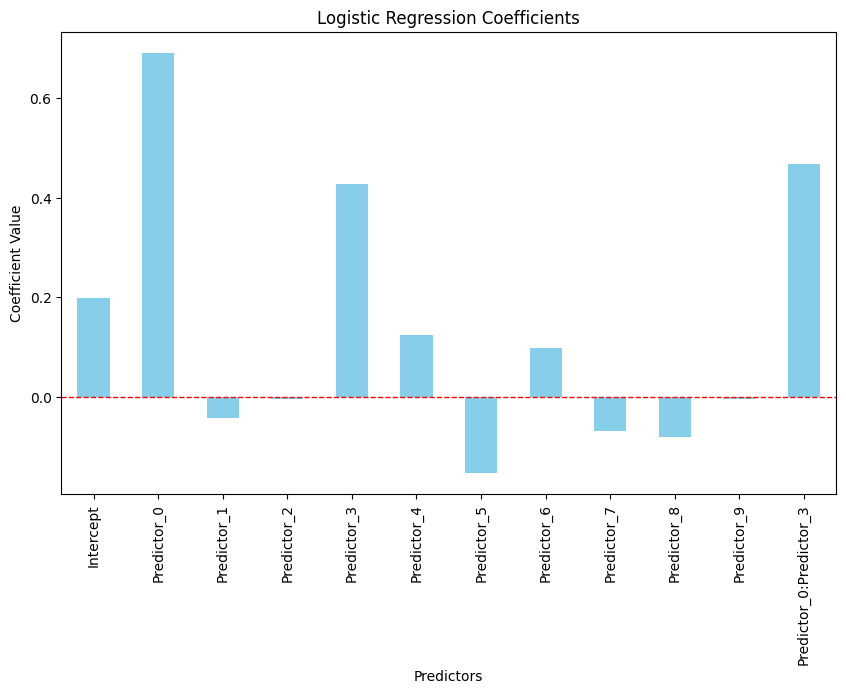

In [8]:
# Extract coefficients and p-values
coefficients = model.params
p_values = model.pvalues

# Plot coefficients
plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar', color='skyblue')
plt.title('Logistic Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Predictors')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.show()

## Comparison Between Distributive and Full Factorial Designs
We will simulate a full factorial design and compare it to the pragmatic distributive design in terms of sample size, power, and efficiency.

Optimization terminated successfully.
         Current function value: 0.571100
         Iterations 6
Sample Size (Distributive Design): 1000
Sample Size (Full Factorial Design): 1024


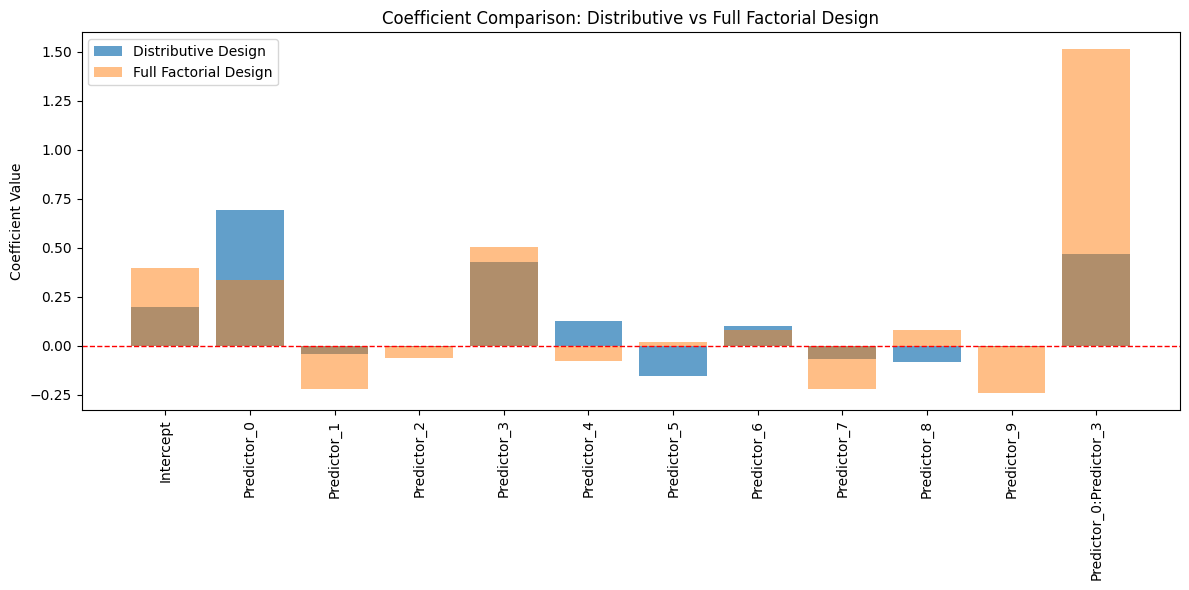

## Pros and Cons of Each Design ##
Distributive Design:
- Lower sample size required
- Efficient for testing multiple factors
- May miss higher-order interactions
Full Factorial Design:
- Comprehensive analysis of all interactions
- Requires exponentially larger sample size
- Less feasible for many predictors


In [9]:
# Full Factorial Design Simulation
# Generate all combinations of predictors (full factorial)
from itertools import product

# Generate all possible combinations of predictor allocations
full_factorial_combinations = list(product([0, 1], repeat=n_predictors))

# Create a DataFrame with full factorial combinations
full_factorial_data = pd.DataFrame(full_factorial_combinations, columns=predictor_names)

# Simulate outcomes for full factorial design
full_factorial_data['HeartDiseaseorAttack'] = full_factorial_data.apply(simulate_outcome, axis=1)

# Logistic regression for full factorial design
full_factorial_model = logit(formula, data=full_factorial_data).fit()

# Compare sample sizes
distributive_sample_size = len(data)
full_factorial_sample_size = len(full_factorial_data)

print(f"Sample Size (Distributive Design): {distributive_sample_size}")
print(f"Sample Size (Full Factorial Design): {full_factorial_sample_size}")

# Compare coefficients and p-values
distributive_coefficients = model.params
full_factorial_coefficients = full_factorial_model.params

# Plot comparison of coefficients
plt.figure(figsize=(12, 6))
plt.bar(distributive_coefficients.index, distributive_coefficients.values, alpha=0.7, label='Distributive Design')
plt.bar(full_factorial_coefficients.index, full_factorial_coefficients.values, alpha=0.5, label='Full Factorial Design')
plt.xticks(rotation=90)
plt.title('Coefficient Comparison: Distributive vs Full Factorial Design')
plt.ylabel('Coefficient Value')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

# Pros and Cons
print("## Pros and Cons of Each Design ##")
print("Distributive Design:")
print("- Lower sample size required\n- Efficient for testing multiple factors\n- May miss higher-order interactions")

print("Full Factorial Design:")
print("- Comprehensive analysis of all interactions\n- Requires exponentially larger sample size\n- Less feasible for many predictors")

## Update Logistic Regression with Kaggle Dataset
We will now use the Kaggle dataset's actual features for our analysis.

In [10]:
# Define features and target
kaggle_features = ['Predictor_0', 'Predictor_1', 'Predictor_2', 'Predictor_3',
       'Predictor_4', 'Predictor_5', 'Predictor_6', 'Predictor_7',
       'Predictor_8', 'Predictor_9']
X = data[kaggle_features]
y = data['HeartDiseaseorAttack']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Remove constant columns
X = X.loc[:, (X != X.iloc[0]).any()]

# Check and remove highly correlated columns
correlation_matrix = X.corr()
correlation_threshold = 0.95
correlated_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            correlated_pairs.add(correlation_matrix.columns[i])
X = X.drop(columns=correlated_pairs)

# Check for any further issues in the data
print("Remaining columns:", X.columns)
print("Dataset shape:", X.shape)

# Fit the logistic regression model
model = sm.Logit(y, X).fit()
print(model.summary())


Remaining columns: Index(['Predictor_0', 'Predictor_1', 'Predictor_2', 'Predictor_3',
       'Predictor_4', 'Predictor_5', 'Predictor_6', 'Predictor_7',
       'Predictor_8', 'Predictor_9'],
      dtype='object')
Dataset shape: (1000, 10)
Optimization terminated successfully.
         Current function value: 0.598629
         Iterations 5
                            Logit Regression Results                            
Dep. Variable:     HeartDiseaseorAttack   No. Observations:                 1000
Model:                            Logit   Df Residuals:                      990
Method:                             MLE   Df Model:                            9
Date:                  Mon, 18 Nov 2024   Pseudo R-squ.:                 0.04845
Time:                          22:03:43   Log-Likelihood:                -598.63
converged:                         True   LL-Null:                       -629.11
Covariance Type:              nonrobust   LLR p-value:                 8.740e-10
           

## Performance and Efficiency Comparison: Distributive vs Full Factorial Design
We will compare the performance (model fit and accuracy) and efficiency (sample size required) of the two designs using the Kaggle dataset.

Optimization terminated successfully.
         Current function value: 0.607502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589576
         Iterations 10
Sample Size (Distributive Design): 350
Sample Size (Full Factorial Design): 700
Accuracy (Distributive Design): 0.65
Accuracy (Full Factorial Design): 0.65


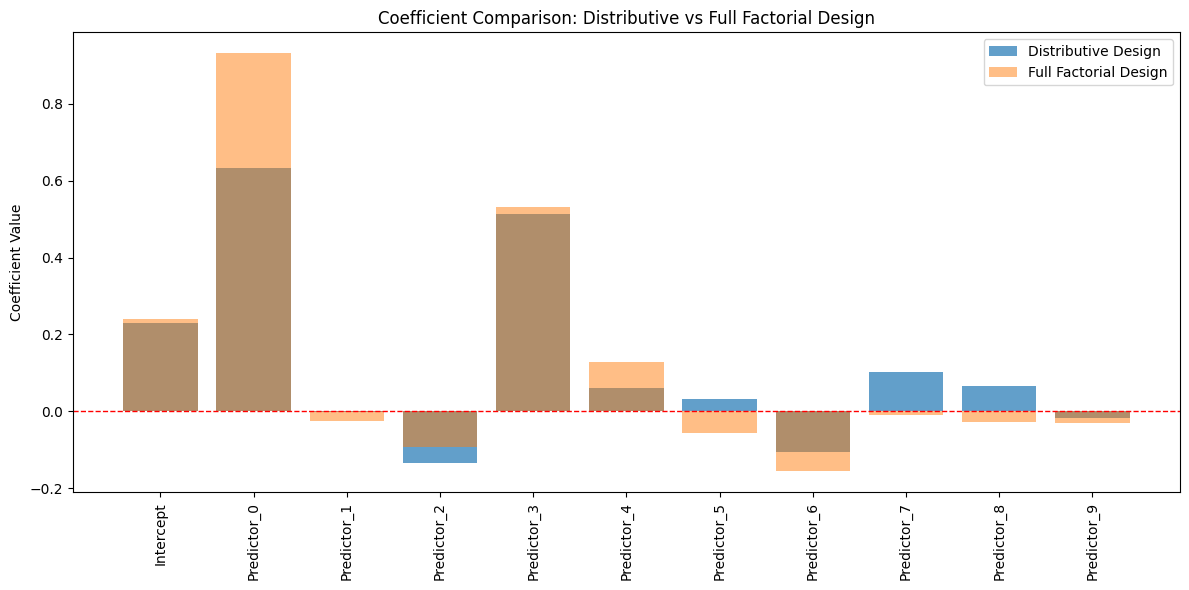

In [11]:
# Comparison Metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Train-test split for the dataset
X = data[kaggle_features]
y = data['HeartDiseaseorAttack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit logistic regression for distributive design (random sampling of features)
distributive_data = X_train.sample(frac=0.5, random_state=42)  # Sample subset of features for distributive design
distributive_data['HeartDiseaseorAttack'] = y_train.loc[distributive_data.index]
distributive_formula = "HeartDiseaseorAttack ~ " + " + ".join(distributive_data.columns[:-1])
distributive_model = logit(distributive_formula, data=distributive_data).fit()

# Fit logistic regression for full factorial design
full_factorial_data = X_train
full_factorial_data['HeartDiseaseorAttack'] = y_train
full_factorial_formula = "HeartDiseaseorAttack ~ " + " + ".join(full_factorial_data.columns[:-1])
full_factorial_model = logit(full_factorial_formula, data=full_factorial_data).fit()

# Predict and calculate accuracy for both models
distributive_preds = distributive_model.predict(X_test)
distributive_preds_binary = (distributive_preds > 0.5).astype(int)
distributive_accuracy = accuracy_score(y_test, distributive_preds_binary)

full_factorial_preds = full_factorial_model.predict(X_test)
full_factorial_preds_binary = (full_factorial_preds > 0.5).astype(int)
full_factorial_accuracy = accuracy_score(y_test, full_factorial_preds_binary)

# Compare sample size, coefficients, and accuracy
distributive_sample_size = len(distributive_data)
full_factorial_sample_size = len(full_factorial_data)

print(f"Sample Size (Distributive Design): {distributive_sample_size}")
print(f"Sample Size (Full Factorial Design): {full_factorial_sample_size}")
print(f"Accuracy (Distributive Design): {distributive_accuracy:.2f}")
print(f"Accuracy (Full Factorial Design): {full_factorial_accuracy:.2f}")

# Plot the coefficients comparison
distributive_coefficients = distributive_model.params
full_factorial_coefficients = full_factorial_model.params

plt.figure(figsize=(12, 6))
plt.bar(distributive_coefficients.index, distributive_coefficients.values, alpha=0.7, label='Distributive Design')
plt.bar(full_factorial_coefficients.index, full_factorial_coefficients.values, alpha=0.5, label='Full Factorial Design')
plt.xticks(rotation=90)
plt.title('Coefficient Comparison: Distributive vs Full Factorial Design')
plt.ylabel('Coefficient Value')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

## Performance Metrics Comparison
We will evaluate and compare the performance metrics of the distributive design and the full factorial design, including accuracy and efficiency.

In [12]:
# Compare Performance Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions for distributive design
distributive_preds = distributive_model.predict(X_test)
distributive_preds_binary = (distributive_preds > 0.5).astype(int)

# Predictions for full factorial design
full_factorial_preds = full_factorial_model.predict(X_test)
full_factorial_preds_binary = (full_factorial_preds > 0.5).astype(int)

# Compute performance metrics
metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1 Score': f1_score
}

print("## Distributive Design Metrics ##")
for metric, func in metrics.items():
    print(f"{metric}: {func(y_test, distributive_preds_binary):.2f}")

print("\n## Full Factorial Design Metrics ##")
for metric, func in metrics.items():
    print(f"{metric}: {func(y_test, full_factorial_preds_binary):.2f}")

# Compare sample sizes
print("\nSample Sizes:")
print(f"Distributive Design: {len(distributive_data)}")
print(f"Full Factorial Design: {len(full_factorial_data)}")

## Distributive Design Metrics ##
Accuracy: 0.65
Precision: 0.65
Recall: 1.00
F1 Score: 0.79

## Full Factorial Design Metrics ##
Accuracy: 0.65
Precision: 0.66
Recall: 0.95
F1 Score: 0.78

Sample Sizes:
Distributive Design: 350
Full Factorial Design: 700


In [ ]:
import statsmodels.api as sm

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print the summary of the model
print(logit_model.summary())

         Current function value: 0.598629
         Iterations: 35
                            Logit Regression Results                            
Dep. Variable:     HeartDiseaseorAttack   No. Observations:                 1000
Model:                            Logit   Df Residuals:                      989
Method:                             MLE   Df Model:                           10
Date:                  Mon, 18 Nov 2024   Pseudo R-squ.:                 0.04845
Time:                          23:21:18   Log-Likelihood:                -598.63
converged:                        False   LL-Null:                       -629.11
Covariance Type:              nonrobust   LLR p-value:                 2.381e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2258        nan        nan        nan         nan         nan
Predictor_0     0.8583        nan        nan  

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


: 